## Required libraries

In [1]:
import imutils
import numpy as np
import os
import cv2
import time
import glob
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, classification_report

from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import (Flatten, Dense, Input, Conv2D, ZeroPadding2D, Dropout,
                          MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D)
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import Input
from keras_applications.imagenet_utils import _obtain_input_shape

# hide all warnings in jupyter
warnings.filterwarnings('ignore')

Using TensorFlow backend.


## Utilities

In [2]:
def read_and_resize_img(path_to_file, resize=None):
    img = cv2.imread(path_to_file)
    if resize:
        img = cv2.resize(img, (resize, resize), cv2.INTER_LINEAR)
    return img

In [3]:
def resize_img(img, resize):
    return cv2.resize(img, (resize, resize), cv2.INTER_LINEAR)

In [4]:
def read_and_show_image(path_to_file, title='Title'):
    image = cv2.imread(path_to_file)
    image = imutils.resize(image, width = 400)
    plot_images(convert_bgr2rgb(image), title)

In [5]:
def extract_mask_and_skin(image, upper, lower):
    """
    resized frame convert to the HSV color space,
    and determine the HSV pixel intensities that fall into
    the speicifed upper and lower boundaries
    """
    converted = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    skin_mask = cv2.inRange(converted, lower, upper)
    
    """    
    apply a series of erosions and dilations to the mask
    using an elliptical kernel
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    # more iterations - less small contours
    skin_mask = cv2.erode(skin_mask, kernel, iterations = 5)
    skin_mask = cv2.dilate(skin_mask, kernel, iterations = 5)
    
    """
    blur the mask to help remove noise, then apply the
    mask to the frame
    """
    skin_mask = cv2.GaussianBlur(skin_mask, (3, 3), 0)
    skin = cv2.bitwise_and(image, image, mask = skin_mask)
    return skin, skin_mask

In [6]:
def convert_bgr2rgb(image):
    """
    to avoid colours inversing while plotting via matplotlib
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:
def plot_images(images, titles, size=15):
    if not isinstance(images, list):
        images = [images]
        titles = [titles]
    plt.figure(figsize=(size, size))
    for i in range(len(images)):
        plt.subplot(1, 3, i + 1), plt.imshow(images[i], 'gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])   
    plt.show()

In [8]:
def find_warning_areas(skin_mask, original_image):
    """
    Function takes as input original image and it's mask 
    and returns original image with areas of probable skin diseases
    """
    cnts = cv2.findContours(skin_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    
    new_image = original_image.copy()

    # computes the bounding box for the contour, and draws it on the image
    for c in cnts:
        rect = cv2.boundingRect(c)
        # if rect[2] < 100 or rect[3] < 100: continue
        # print cv2.contourArea(c)
        x,y,w,h = rect
        cv2.rectangle(new_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # cv2.putText(image,'skin disease',(x + w + 10,y + h), 0, 0.5, (0, 255, 0))
    return new_image

In [9]:
def general_warning_area(skin_mask, original_image):
    """
    Function takes as input original image and it's mask 
    and returns original images with general area of all areas of probable skin disease
    """
    cnts = cv2.findContours(skin_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = cnts[0] if imutils.is_cv2() else cnts[1]

    new_image = original_image.copy()
    height, width, _ = new_image.shape
    min_x, min_y = width, height
    max_x = max_y = 0
    
    # computes the bounding box for the contour, and draws it on the image
    for contour in contours:
        (x,y,w,h) = cv2.boundingRect(contour)
        min_x, max_x = min(x, min_x), max(x+w, max_x)
        min_y, max_y = min(y, min_y), max(y+h, max_y)
    #     if w > 80 and h > 80:
    #         cv2.rectangle(image, (x,y), (x+w,y+h), (255, 0, 0), 2)

    if max_x - min_x > 0 and max_y - min_y > 0:
        cv2.rectangle(new_image, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
    cropped_image = new_image[min_y:max_y, min_x:max_x].copy()
    
    return new_image, cropped_image

In [10]:
def proba_to_classes(y_proba):
    if len(y_proba[0]) == 2:
        return np.array([list(map(round, item)) for item in y_proba])
    else:
        y_pred = []
        for lst in y_proba:
            max_lst = max(lst)
            for i, j in enumerate(lst):
                if j == max_lst:
                    max_ind = i
                    break
            lst1 = [0]*len(lst)
            lst1[max_ind] = 1
            y_pred.append(lst1)
        return  np.array(y_pred)

## HSV skin parameters

In [11]:
# skin #1
lower_skin = np.array([0, 70, 80], dtype = "uint8")
upper_skin = np.array([20, 200, 255], dtype = "uint8")

# skin #2
# lower_skin = np.array([0, 10, 60], dtype = "uint8") 
# upper_skin = np.array([20, 150, 255], dtype = "uint8")

# acne
lower_acne = np.array([0, 70, 50], dtype = "uint8") 
upper_acne = np.array([10, 255, 255], dtype = "uint8")

## Extracting skin

In [12]:
# original_image = 'demo_images/pretty_face.jpg'
original_image = 'demo_images/test-acne.jpg'
image_sample = read_and_resize_img(original_image)

In [13]:
skin, skin_mask = extract_mask_and_skin(image_sample, upper=upper_skin, lower=lower_skin)

In [14]:
images = [convert_bgr2rgb(image_sample), skin_mask, convert_bgr2rgb(skin)]

titles = ['Original Image','Masked Image', 'Processed Image']

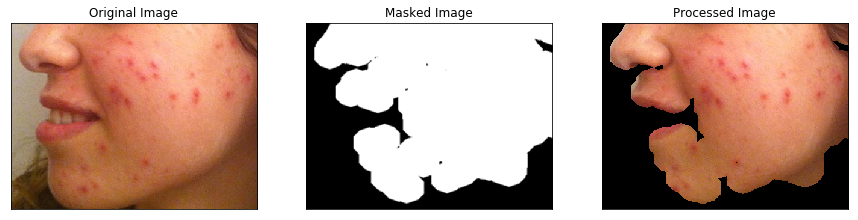

In [15]:
plot_images(images, titles)

## Extracting skin disease 

In [16]:
# original_image = 'demo_images/test-acne.jpg'
# image_sample = read_and_resize_img(original_image)
image_sample1 = skin.copy()

In [17]:
skin, skin_mask = extract_mask_and_skin(image_sample, upper=upper_acne, lower=lower_acne)

In [18]:
images = [convert_bgr2rgb(image_sample1), skin_mask, convert_bgr2rgb(skin)]

titles = ['Original Image','Masked Image', 'Processed Image']

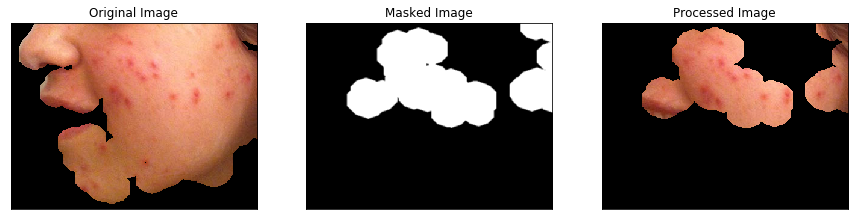

In [19]:
plot_images(images, titles)

In [20]:
new_image = find_warning_areas(skin_mask, original_image=image_sample)

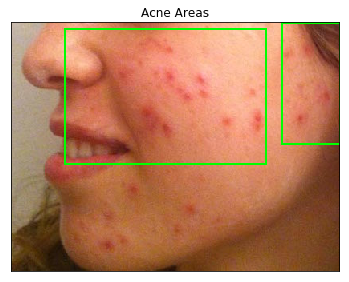

In [21]:
plot_images([convert_bgr2rgb(new_image)], ['Acne Areas'], 20)

In [22]:
image = general_warning_area(skin_mask, original_image=image_sample)[0]
cropped_image = general_warning_area(skin_mask, original_image=image_sample)[1]

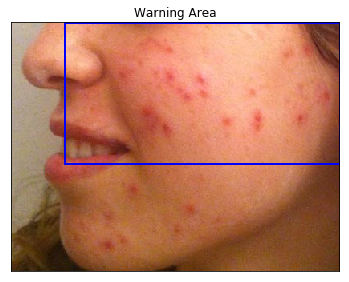

In [23]:
plot_images([convert_bgr2rgb(image)], ['Warning Area'], 20)

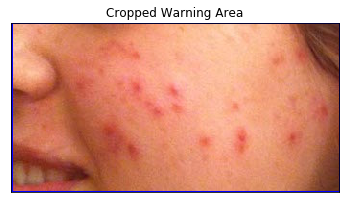

In [24]:
plot_images([convert_bgr2rgb(cropped_image)], ['Cropped Warning Area'], 20)

## Training CNN model

### utilities

In [45]:
def read_and_resize_img(path_to_file, resize=None):
    img = cv2.imread(path_to_file)
    if resize:
        img = cv2.resize(img, (resize, resize), cv2.INTER_LINEAR)
    return img


def load_train(size, folders):
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Read train images')
    # folders = ['Acne and Rosacea Photos', 'Eczema Photos']
    for fld in folders:
        index = folders.index(fld)
        path = os.path.join('data', fld, '*.jpg')
        files = glob.glob(path)
        print(f'Load folder "{fld}" with {len(files)} files (Index: {index})')
        for fl in files:
            flbase = os.path.basename(fl)
            img = read_and_resize_img(fl, size)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(index)

    print('Read train data time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id


def read_and_normalize_train_data(size, folders):
    train_data, train_target, train_id = load_train(size, folders)

    print('Convert to numpy...')
    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)

    # if neaded
    # print('Reshape...')
    # train_data = train_data.transpose((0, 3, 2, 1))

    print('Convert to float...')
    train_data = train_data.astype('float32')
    train_data = train_data / 255
    train_target = np_utils.to_categorical(train_target, len(folders))

    print('Train shape:', train_data.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target, train_id


def make_prediction(model, img):
    test_model_img = np.array([img], dtype=np.uint8)
    test_model_img = test_model_img.astype('float32')
    test_model_img = test_model_img / 255
    return dict(zip(image_folders, model.predict(test_model_img)[0]))

### neural network architecture

In [26]:
def vgg16_example(classes, input_shape=None, include_top=True, pooling=None):
    """
    Model based architecture
    """
    
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)
    
    img_input = Input(shape=input_shape)

    # Block 1
    x = Conv2D(4, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv2D(4, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(8, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

    if include_top:
        # Classification block
        x = Flatten(name='flatten')(x)
        x = Dense(128, activation='relu', name='fc1')(x)
        x = Dense(128, activation='relu', name='fc2')(x)
        x = Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Create model
    model = Model(img_input, x, name='custom_vgg16')
    return model

In [27]:
def small_VGG16(input_shape, n_classes):
    
    model = Sequential()
    
    model.add(Conv2D(4, (3, 3), activation='relu', input_shape=input_shape))
    model.add(Conv2D(4, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(Conv2D(8, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))
    
    return model

In [28]:
def deep_VGG16(input_shape, n_classes):
    
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=input_shape))
    model.add(Conv2D(4, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(4, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(8, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(8, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(16, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(16, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(16, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    return model

### data observing and training

In [29]:
DATA_DIR = os.path.join(os.getcwd(), 'data')

image_folders = os.listdir(DATA_DIR)
image_folders.remove('imageUrls.p')
image_folders.sort()

images = os.listdir(os.path.join(DATA_DIR, image_folders[0]))
images.sort()

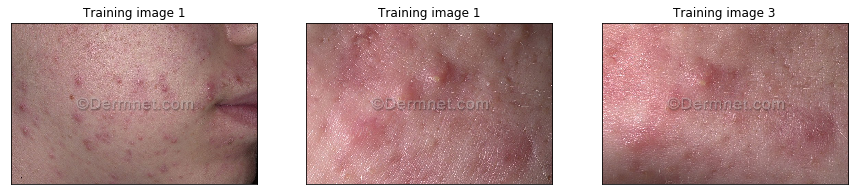

In [30]:
images_to_plot = [
    convert_bgr2rgb(
        read_and_resize_img(os.path.join(DATA_DIR, image_folders[0], images[1]))
    ), 
    convert_bgr2rgb(
        read_and_resize_img(os.path.join(DATA_DIR, image_folders[0], images[2]))
    ), 
    convert_bgr2rgb(
        read_and_resize_img(os.path.join(DATA_DIR, image_folders[0], images[3]))
    )
]

titles = ['Training image 1','Training image 1', 'Training image 3']

plot_images(images_to_plot, titles)

In [31]:
train_data, train_target, train_id = read_and_normalize_train_data(64, image_folders)

num_classes = len(image_folders)

Read train images
Load folder "Acne and Rosacea" with 888 files (Index: 0)
Load folder "Bullous Disease" with 561 files (Index: 1)
Load folder "Eczema" with 1544 files (Index: 2)
Load folder "Melanoma" with 579 files (Index: 3)
Read train data time: 12.27 seconds
Convert to numpy...
Convert to float...
Train shape: (3572, 64, 64, 3)
3572 train samples


In [32]:
X_train, X_test, y_train, y_test = train_test_split(train_data,
                                                    train_target,
                                                    test_size=0.25,
                                                    random_state=256)

In [33]:
print('Training data', X_train.shape)

Training data (2679, 64, 64, 3)


In [34]:
print('Creating model...')
model = small_VGG16(X_train[0].shape, num_classes)

# model.compile(optimizer='rmsprop',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])



sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5),
]

history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=100,
                    shuffle=True,
                    verbose=1,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)

Creating model...
Train on 2679 samples, validate on 893 samples
Epoch 1/100
2679/2679 [==============================] - 3s 1ms/step - loss: 1.3472 - acc: 0.4143 - val_loss: 1.2978 - val_acc: 0.4390
Epoch 2/100
2679/2679 [==============================] - 3s 1ms/step - loss: 1.3015 - acc: 0.4300 - val_loss: 1.2882 - val_acc: 0.4390
Epoch 3/100
2679/2679 [==============================] - 3s 1ms/step - loss: 1.2988 - acc: 0.4300 - val_loss: 1.2888 - val_acc: 0.4390
Epoch 4/100
2679/2679 [==============================] - 3s 1ms/step - loss: 1.2985 - acc: 0.4300 - val_loss: 1.2886 - val_acc: 0.4390
Epoch 5/100
2679/2679 [==============================] - 3s 1ms/step - loss: 1.2983 - acc: 0.4300 - val_loss: 1.2879 - val_acc: 0.4390
Epoch 6/100
2679/2679 [==============================] - 3s 1ms/step - loss: 1.2972 - acc: 0.4300 - val_loss: 1.2881 - val_acc: 0.4390
Epoch 7/100
2679/2679 [==============================] - 3s 1ms/step - loss: 1.2981 - acc: 0.4300 - val_loss: 1.2882 - val_ac

### Plot learning rate

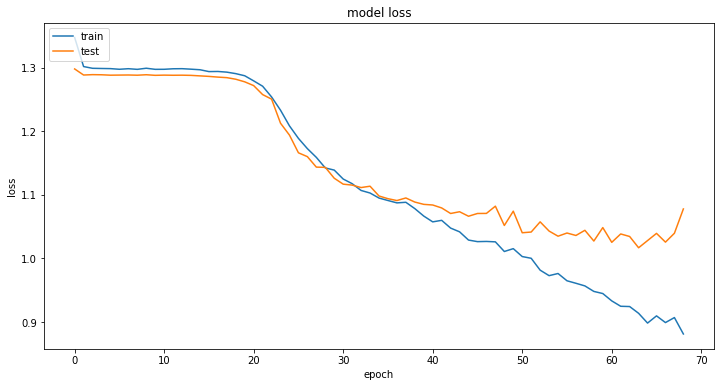

In [35]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

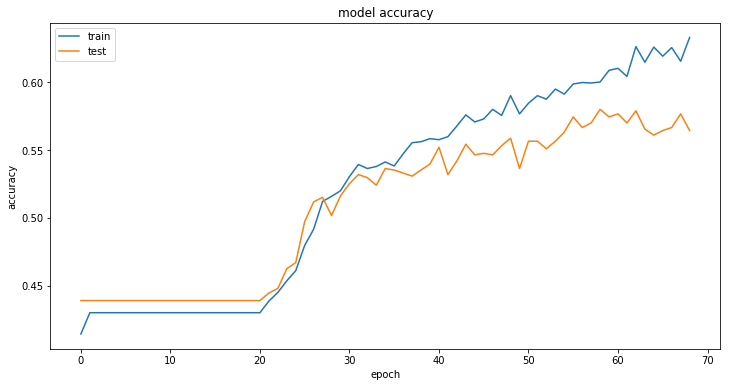

In [36]:
plt.figure(figsize=(12,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
y_proba = model.predict(X_test.astype('float32'),
                            batch_size=128)
y_pred = proba_to_classes(y_proba)

In [38]:
metrics = {
    'loglos': log_loss(y_test, y_proba),
    'accuracy': accuracy_score(y_test, y_pred),
    'precission': precision_score(y_test, y_pred, average='weighted'),
    'recall': recall_score(y_test, y_pred, average='weighted'),
    'f1_score': f1_score(y_test, y_pred, average='weighted')
}

### Training results and predicting sample image

In [39]:
print('***** Metrics *****\n')
for k, v in metrics.items():
    print(f"{k}:\t {v:.4}".expandtabs(12))

***** Metrics *****

loglos:      1.078
accuracy:    0.5644
precission:  0.5835
recall:      0.5644
f1_score:    0.5538


In [40]:
print(classification_report(y_test, y_pred, target_names=image_folders[:5]))

                  precision    recall  f1-score   support

Acne and Rosacea       0.43      0.72      0.54       221
 Bullous Disease       0.47      0.19      0.27       139
          Eczema       0.69      0.65      0.67       392
        Melanoma       0.63      0.45      0.53       141

     avg / total       0.58      0.56      0.55       893



In [41]:
#model.save('models/simple_vgg16_1.h5')

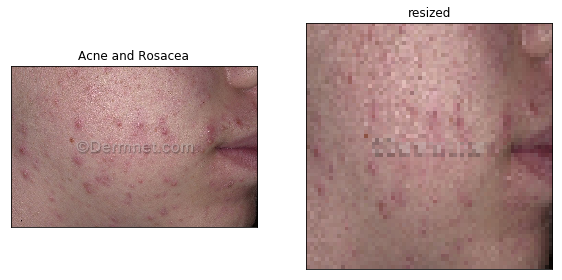

In [117]:
images = os.listdir(os.path.join(DATA_DIR, image_folders[0]))
images.sort()

path_to_file = os.path.join(DATA_DIR, image_folders[0], images[1])

original_image = cv2.imread(path_to_file)
resized_image = read_and_resize_img(path_to_file, 64)
plot_images([convert_bgr2rgb(original_image), convert_bgr2rgb(resized_image)], 
            [image_folders[0], 'resized'])

In [118]:
print('****** PREDICT IMAGE *****\n')
print('Class\t Probability\n'.expandtabs(20))
for k, v in make_prediction(model, resized_image).items():
    print(f'{k}\t {v:.4}'.expandtabs(20))

****** PREDICT IMAGE *****

Class                Probability

Acne and Rosacea     0.7212
Bullous Disease      0.05878
Eczema               0.1969
Melanoma             0.02313
